In [2]:
# Import all the necessary libraries
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score, recall_score, f1_score,ConfusionMatrixDisplay,classification_report


import warnings 
warnings.filterwarnings("ignore")

In [33]:
cri_compustat_merged = pd.read_pickle("cri_compustat_merged_v6.pkl")
cri_compustat_merged.shape[0]

1179414

In [37]:
cri_compustat_merged['tic']

0          CDSI.2
1            DXPE
2            ZICA
3            XLTC
4            MRYP
            ...  
1179409        DE
1179410       WSM
1179411       DDS
1179412       BBY
1179413      DXLG
Name: tic, Length: 1179414, dtype: object

In [34]:
yfinance = pd.read_pickle("final_yfiance.pkl")
yfinance.shape

(1829792, 8)

In [40]:
yfinance = yfinance.rename(columns={"yyyy":"year"})
yfinance = yfinance.rename(columns={"mm":"month"})
yfinance

,tic,yyyy,mm,Rolling_Sortino,macd,macd_h,macd_s,rsi
0,A,2000,2,NaN,1.075967,0.860774,0.215193,100.000000
1,A,2000,3,NaN,3.969328,3.003308,0.966020,100.000000
2,A,2000,4,NaN,4.539882,2.859089,1.680793,65.530596
3,A,2000,5,NaN,4.087595,1.925442,2.162153,55.676209
4,A,2000,6,NaN,3.326092,0.931151,2.394941,52.327200
...,...,...,...,...,...,...,...,...
1829787,ZZZOF,2023,1,-10.560671,-0.612086,0.180779,-0.792866,31.538242
1829788,ZZZOF,2023,2,-13.056398,-0.577128,0.172590,-0.749718,33.238700
1829789,ZZZOF,2023,3,-12.786201,-0.546051,0.162933,-0.708985,32.361822
1829790,ZZZOF,2023,4,-16.810842,-0.514913,0.155257,-0.670170,32.844994


In [ ]:
cri_compustat_yfinance = cri_compustat_merged.merge(yfinance, on=['tic','year','month'], how='inner')

In [18]:
cri_compustat_merged.isna().sum()

CompNo                         0
year                           0
month                          0
StkIndx                        0
STInt                          0
dtdlevel                       0
dtdtrend                       0
liqnonfinlevel                 0
liqnonfintrend                 0
ni2talevel                     0
ni2tatrend                     0
sizelevel                      0
sizetrend                      0
m2b                            0
sigma                          0
liqfinlevel                    0
lqfintrend                     0
DTDmedianFin                   0
DTDmedianNonFin                0
dummy297fin                    0
Default                        0
day                            0
date                           0
StartDate                      0
EventDate                      0
Duration                       0
gvkey                          0
current_ratio                  0
quick_ratio                    0
cash_ratio                     0
net_workin

In [19]:
cri_compustat_merged['EventDate']

0         2000-01-31
1         2000-01-31
2         2000-01-31
3         2000-01-31
4         2000-01-31
             ...    
1179409   2023-07-31
1179410   2023-07-31
1179411   2023-07-31
1179412   2023-07-31
1179413   2023-07-31
Name: EventDate, Length: 1179414, dtype: datetime64[ns]

In [20]:
#refactor
cols = list(cri_compustat_merged.columns)

cri_compustat_merged.sort_values(by='EventDate', inplace=True)
date2022 = datetime.datetime(2022, 1, 1)
date2020 = datetime.datetime(2020,1,1)
train_df = cri_compustat_merged[cri_compustat_merged["EventDate"] < date2020]
validation_df = cri_compustat_merged[(cri_compustat_merged["EventDate"] >= date2020) & (cri_compustat_merged["EventDate"] < date2022)]
test_df = cri_compustat_merged[cri_compustat_merged["EventDate"] >= date2022]

In [25]:
len(cri_compustat_merged[cri_compustat_merged['Default'] == 1])/len(cri_compustat_merged)*100

0.7903925169618133

In [24]:
len(validation_df[validation_df['Default'] == 1])/len(validation_df) *100

0.5420333110344946

In [26]:
len(test_df[test_df['Default'] == 1])/len(test_df) *100

0.42696444699893255

In [7]:
cri_compustat_merged[cri_compustat_merged['Default'] == 1]

,CompNo,year,month,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,working_capital_turnover,price_to_earnings,dividend_payout_ratio,retention_ratio,gross_margin_ratio,operating_profit_margin,ebitda_margin,debt_service_coverage_ratio,interest_coverage_ratio,tic
4655,28611,2000.0,1,0.089239,0.011089,0.756315,0.546429,0.301765,0.286080,-0.014388,...,-0.000000,46.153846,-0.0,1.0,36.490270,-4.708875e+01,-3.332780e+01,-0.126920,1.876995,UBMSQ
4676,34602,2000.0,1,0.089239,0.011089,0.980684,-0.365880,-0.033778,-0.118834,-0.001747,...,2.122705,-1.875000,-0.0,1.0,33.220235,-8.781080e+01,-8.606458e+01,-0.980703,-6.932852,FRAE
4700,40983,2000.0,1,0.089239,0.011089,0.287877,-0.785039,1.117781,-0.134035,-0.002720,...,-2.546999,-0.128240,-0.0,1.0,64.491489,-4.249063e+00,3.802359e+01,-0.027480,8.689003,SSINQ
5031,27240,2000.0,1,0.089239,0.011089,1.608767,-0.579390,0.546160,0.131284,-0.001938,...,2.072832,-0.714286,-0.0,1.0,6.380575,-1.007847e+02,-9.646779e+01,-0.394548,-1.173697,CQB
4808,29969,2000.0,1,0.089239,0.011089,0.480276,0.613480,0.701922,0.042428,-0.005224,...,-0.844392,-0.030058,-0.0,1.0,3.667787,-1.013477e+02,-9.821682e+01,-1.066224,-0.988917,MM.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1173086,30473,2023.0,3,-0.092950,0.007115,-0.761189,-0.147672,1.021671,-0.218530,-0.034514,...,-0.483450,-0.176829,-0.0,1.0,27.335511,-7.955085e+01,-7.106463e+01,-0.100127,-0.365241,LCINQ
1171271,27346,2023.0,3,-0.092950,0.007115,-1.113511,0.000000,0.098426,0.000000,-0.016226,...,7.346535,-0.857143,-0.0,1.0,28.008907,-6.484238e+01,-6.139693e+01,-0.208368,0.744811,DBD
1171740,46481,2023.0,3,-0.092950,0.007115,0.622700,-0.098017,1.692032,0.166245,-0.036078,...,0.000000,-0.868966,-0.0,1.0,-324.793063,-2.189250e+07,-2.185540e+07,-1.577718,-219.857143,RGTPQ
1174492,27346,2023.0,4,-0.027527,0.008456,-1.113511,-0.055722,0.098426,0.000000,-0.016226,...,7.346535,-0.857143,-0.0,1.0,28.008907,-6.484238e+01,-6.139693e+01,-0.208368,0.744811,DBD


In [16]:
cri_compustat_merged.columns

Index(['CompNo', 'year', 'month', 'StkIndx', 'STInt', 'dtdlevel', 'dtdtrend',
       'liqnonfinlevel', 'liqnonfintrend', 'ni2talevel', 'ni2tatrend',
       'sizelevel', 'sizetrend', 'm2b', 'sigma', 'liqfinlevel', 'lqfintrend',
       'DTDmedianFin', 'DTDmedianNonFin', 'dummy297fin', 'Default', 'day',
       'date', 'StartDate', 'EventDate', 'Duration', 'gvkey', 'current_ratio',
       'quick_ratio', 'cash_ratio', 'net_working_capital', 'debt_ratio',
       'debt_to_equity_ratio', 'equity_ratio', 'cashflow_to_debt_ratio',
       'net_profit_margin', 'return_on_assets', 'asset_turnover',
       'inventory_turnover', 'days_in_inventory', 'receivables_turnover',
       'day_sales_outstanding', 'working_capital_turnover',
       'price_to_earnings', 'dividend_payout_ratio', 'retention_ratio',
       'gross_margin_ratio', 'operating_profit_margin', 'ebitda_margin',
       'debt_service_coverage_ratio', 'interest_coverage_ratio', 'tic'],
      dtype='object')

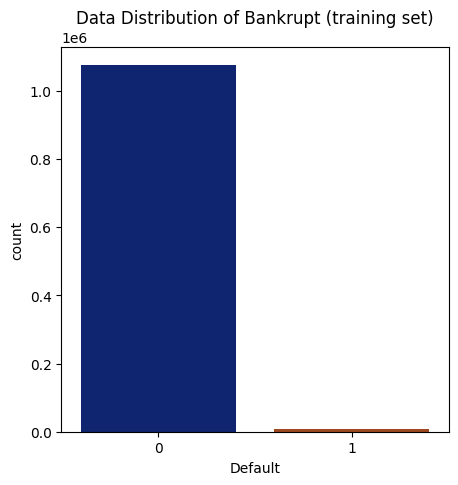

Imbalance Ratio is:121.55118644067797
 % of default is :0.008159855722686613


In [8]:
plt.figure(figsize=(5,5))
sns.countplot(x=train_df["Default"], palette="dark")
plt.title("Data Distribution of Bankrupt (training set)")
plt.show()
majority_class_samples=train_df["Default"].loc[train_df["Default"]==0]
minority_class_samples=train_df["Default"].loc[train_df["Default"]==1]
Imbalance_Ratio= len(majority_class_samples)/len(minority_class_samples)
percentage = len(minority_class_samples)/(len(minority_class_samples)+len(majority_class_samples))
print(f"Imbalance Ratio is:{Imbalance_Ratio}")
print(f" % of default is :{percentage}") 

In [9]:
# drop unecessary columns
train_df.drop(["CompNo", "year", "month", "day", "date"], axis=1, inplace=True)
validation_df.drop(["CompNo", "year", "month", "day", "date"], axis=1, inplace=True)
test_df.drop(["CompNo", "year", "month", "day", "date"], axis=1, inplace=True)

In [10]:
x_train = train_df.drop('Default', axis=1)
y_train = train_df['Default']
x_validation = validation_df.drop('Default', axis=1)
y_validation = validation_df['Default']
x_test = test_df.drop('Default', axis=1)
y_test = test_df["Default"]

In [11]:
def get_num_cat_columns(dataframe):
    categorical_cols=dataframe.select_dtypes(include="object").columns
    numerical_cols=dataframe.select_dtypes(exclude="object").columns
    
    return categorical_cols, numerical_cols

In [12]:
categorical_cols, numerical_cols= get_num_cat_columns(x_train)

In [13]:
def Winsorization_Method(columns, x_train, y_train , a, b):
    outliers=[]

    for col in columns:
        q1= np.percentile(x_train[col], a)
        q2= np.percentile(x_train[col],b)
        
        for pos in range(len(x_train)):
            if x_train[col].iloc[pos]>q2 or x_train[col].iloc[pos]<q1:
                outliers.append(pos) 
                
    outliers= set(outliers)                   # remove the duplicates from the outliers
    outliers= list(outliers)
    
    ratio= round(len(outliers)/len(x_train)*100, 2)                       # Ratio of outliers
    x_train.drop(x_train.index[outliers], inplace=True)    # remove the outliers from the training dataset
    y_train.drop(y_train.index[outliers], inplace=True)
    
    
    
    return ratio, x_train, y_train

In [14]:
ratio, x_train, y_train= Winsorization_Method(numerical_cols, x_train, y_train,a=0.3,b=99.7)
print(f"Ratio of Outliers Detected in the dataset:{ratio}")

Ratio of Outliers Detected in the dataset:13.55


In [14]:
# shape of data after removing the outliers in the training data
x_train.shape,x_test.shape,x_validation.shape ,y_train.shape, y_test.shape, y_validation.shape

((1084578, 46), (36537, 46), (58299, 46), (1084578,), (36537,), (58299,))

In [16]:
x_train.to_csv("../Dataset/" + "X_train_winsorized.csv", index=False)

In [17]:
x_test.to_csv("../Dataset/" + "X_test.csv", index=False)

In [18]:
x_validation.to_csv("../Dataset/" + "X_validation.csv", index=False)

In [19]:
y_train.to_csv("../Dataset/" + "Y_train_winsorized.csv", index=False)

In [20]:
y_test.to_csv("../Dataset/" + "Y_test.csv", index=False)

In [21]:
y_validation.to_csv("../Dataset/" + "Y_validation.csv", index=False)